# Unmixing test

Over irrigation locations near Canberra and in VIC.
  
Use time series to capture cover variability over time.

In [1]:
## Imports

import os
import glob
from pathlib import Path
from datetime import datetime
import rioxarray as rxr
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
#from rios import applier, fileinfo
from netCDF4 import Dataset
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from tools.emit_tools_new import emit_xarray, band_mask

import xarray as xr
import zarr
from rasterio.enums import Resampling

import gc
gdal.UseExceptions()


In [2]:
# Pivot near Canberra
min_lat, max_lat = -35.32, -35.30
min_lon, max_lon = 149.16, 149.18

emit_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230316T045211_2307503_006/EMIT_L2A_RFL_001_20230316T045211_2307503_006_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240325T002836_2408415_019/EMIT_L2A_RFL_001_20240325T002836_2408415_019_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240901T013648_2424501_059/EMIT_L2A_RFL_001_20240901T013648_2424501_059_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240923T002255_2426615_009/EMIT_L2A_RFL_001_20240923T002255_2426615_009_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20241029T023534_2430302_057/EMIT_L2A_RFL_001_20241029T023534_2430302_057_masked.tif',
]

zarr_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230316T045211_2307503_006/EMIT_L2A_RFL_001_20230316T045211_2307503_006_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240325T002836_2408415_019/EMIT_L2A_RFL_001_20240325T002836_2408415_019_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240901T013648_2424501_059/EMIT_L2A_RFL_001_20240901T013648_2424501_059_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240923T002255_2426615_009/EMIT_L2A_RFL_001_20240923T002255_2426615_009_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20241029T023534_2430302_057/EMIT_L2A_RFL_001_20241029T023534_2430302_057_masked.zarr',
]


In [92]:
# Irrigation area in VIC
min_lat, max_lat = -38.1, -38.0
min_lon, max_lon = 146.8, 147.0

emit_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250305T004702_2506401_039/EMIT_L2A_RFL_001_20250305T004702_2506401_039_masked.tif'
]

zarr_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250305T004702_2506401_039/EMIT_L2A_RFL_001_20250305T004702_2506401_039_masked.zarr'
]

enmap_paths = [
    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000063368_20240229T005105Z_015_V010401_20240306T141210Z-SPECTRAL_IMAGE_COG.TIF',
#    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000064649_20240308T005824Z_002_V010401_20240309T171044Z-SPECTRAL_IMAGE_COG.TIF',
#    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000064649_20240308T005828Z_003_V010401_20240309T171343Z-SPECTRAL_IMAGE_COG.TIF'
]

## Load EMIT

In [52]:
%%time

ds_stack = []
for i in range(len(zarr_paths)):
    zarr_path = zarr_paths[i]
    # time dimension
    date_time_obj = datetime.strptime(Path(zarr_path).name.split('_')[4], "%Y%m%dT%H%M%S")
    
    ds_subset = xr.open_zarr(zarr_path, consolidated=True, chunks={}).reflectance.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon, max_lon))
    ds_subset = ds_subset.rio.write_crs("EPSG:4326")
    if np.min(ds_subset.shape)>0:
        ds_subset = ds_subset.transpose("bands", "latitude", "longitude").compute()
        ds_subset = ds_subset.rename({"latitude":'y',"longitude":'x'})
        if len(ds_stack)>0:
            ds_subset = ds_subset.rio.reproject_match(ds_stack[0], resampling = Resampling.nearest)
        
        ds_stack.append(ds_subset.expand_dims(dim={"time":[date_time_obj]}))
    else:
        print("no data found in", zarr_path)

CPU times: user 219 ms, sys: 48.1 ms, total: 267 ms
Wall time: 5.09 s


In [53]:
ds = xr.concat(ds_stack, dim="time")
ds = ds.rename({"bands":"band"})

In [54]:
ndvi = (ds.sel(bands=842, method='nearest') - ds.sel(bands=665, method='nearest')) / (ds.sel(bands=842, method='nearest') + ds.sel(bands=665, method='nearest'))

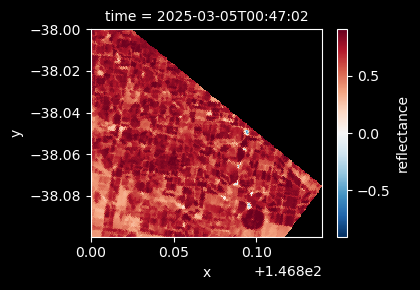

In [55]:
ndvi.plot.imshow(col='time');

In [141]:
%%time

ds_stack = []
for i in range(len(emit_paths)):
    tif_path = emit_paths[i]
    # time dimension
    date_time_obj = datetime.strptime(Path(tif_path).name.split('_')[4], "%Y%m%dT%H%M%S")
    
    ds_subset = rxr.open_rasterio(tif_path, chunks={}).sel(y=slice(max_lat, min_lat), x=slice(min_lon, max_lon))
    if np.min(ds_subset.shape)>0:
        ds_subset = ds_subset.compute()
        if len(ds_stack)>0:
            ds_subset = ds_subset.rio.reproject_match(ds_stack[0], resampling = Resampling.nearest)
        
        ds_stack.append(ds_subset.expand_dims(dim={"time":[date_time_obj]}))
    else:
        print("no data found in", tif_path)

CPU times: user 236 ms, sys: 158 ms, total: 394 ms
Wall time: 9.35 s


In [142]:
ds = xr.concat(ds_stack, dim="time")

In [143]:
ds['band'] = np.array(ds.attrs['long_name']).astype(int)

In [144]:
ndvi = (ds.sel(band=842, method='nearest') - ds.sel(band=665, method='nearest')) / (ds.sel(band=842, method='nearest') + ds.sel(band=665, method='nearest'))

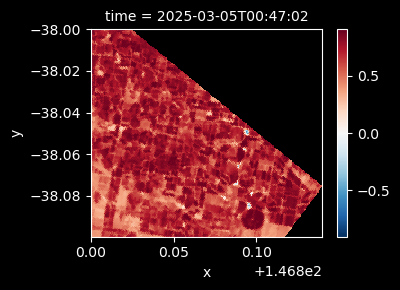

In [145]:
ndvi.plot.imshow(col='time');

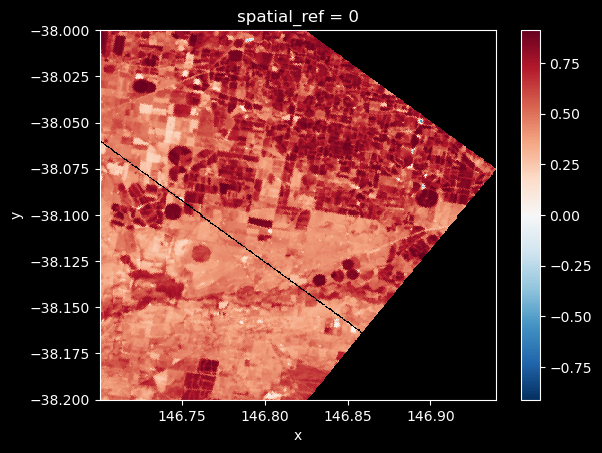

In [37]:
ndvi.min(dim='time').plot.imshow();

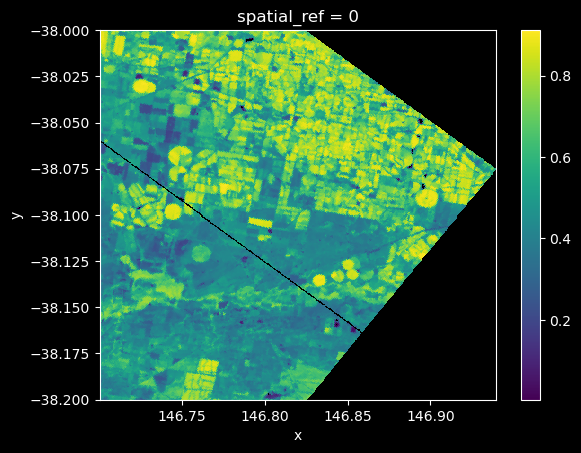

In [38]:
mask = ndvi.min(dim='time')>0
ndvi.mean(dim='time').where(mask).plot.imshow();

In [56]:
ds_emit= ds

## Load ENMAP

In [93]:
%%time

ds_stack = []
for i in range(len(enmap_paths)):
    tif_path = enmap_paths[i]
    # time dimension
    date_time_obj = datetime.strptime(Path(tif_path).name.split('_')[5], "%Y%m%dT%H%M%SZ")
    
    ds_subset = rxr.open_rasterio(tif_path, chunks={}).rio.reproject_match(ds_emit, resampling = Resampling.nearest).sel(y=slice(max_lat, min_lat), x=slice(min_lon, max_lon))
    if np.min(ds_subset.shape)>0:
        ds_subset = ds_subset.compute()
        if len(ds_stack)>0:
            ds_subset = ds_subset.rio.reproject_match(ds_stack[0], resampling = Resampling.nearest)
        
        ds_stack.append(ds_subset.expand_dims(dim={"time":[date_time_obj]}))
    else:
        print("no data found in", tif_path)

CPU times: user 2.66 s, sys: 330 ms, total: 2.99 s
Wall time: 3.34 s


In [94]:
ds = xr.concat(ds_stack, dim="time")

In [95]:
ds = ds.where(ds > 0, np.nan)
ds = ds/10000

In [96]:
#this is not right, need to convert band number to wavelengths
ndvi = (ds.sel(band=842, method='nearest') - ds.sel(band=665, method='nearest')) / (ds.sel(band=842, method='nearest') + ds.sel(band=665, method='nearest'))

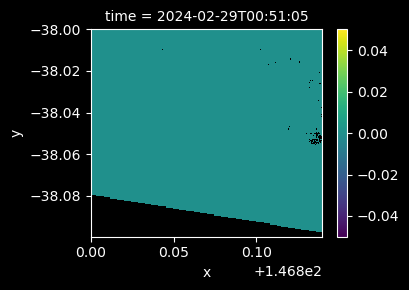

In [124]:
ndvi.plot.imshow(col='time', robust=True);

### Plot EMIT Spectra


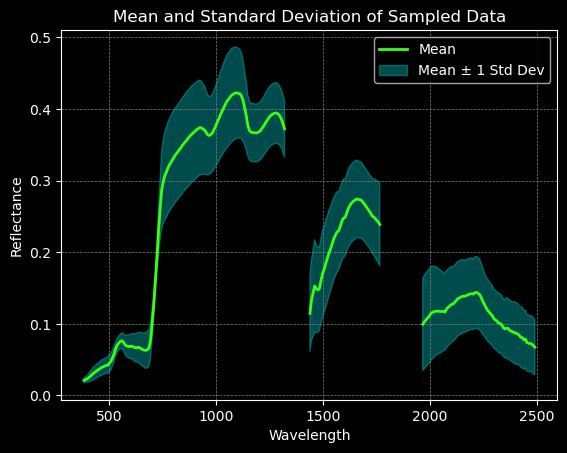

In [146]:
# Set the black background
plt.style.use('dark_background')

mean = ds.isel(time=0).mean(['y','x'])
std_dev = ds.isel(time=0).std(['y','x'])

mean = mean.where(mean>0)
std_dev = std_dev.where(std_dev>0)

mean.plot(label='Mean', color='#39FF14', linewidth=2)  # Neon green line

plt.fill_between(mean.band, mean - std_dev, mean + std_dev, color='#00FFFF', alpha=0.3, label='Mean ± 1 Std Dev')  # Neon cyan shading

# Customize the plot with labels, title, legend, and grid
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('Mean and Standard Deviation of Sampled Data', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)


## Clean the DATA

In [161]:
wavelengths = ds.band
dat = ds.transpose('band','y','x','time').data
# Reshape to (bands, pixels)
dat = dat.reshape((dat.shape[0], -1))
valid = ~np.any(np.isnan(dat), axis=0)
dat = dat[:, valid]

# Find the indicies of the bands where the minumum is all less than 0
bad_bands = np.all(dat < 0, axis=1)
print(f'Bad bands: {np.where(bad_bands)[0]}')

Bad bands: [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212]


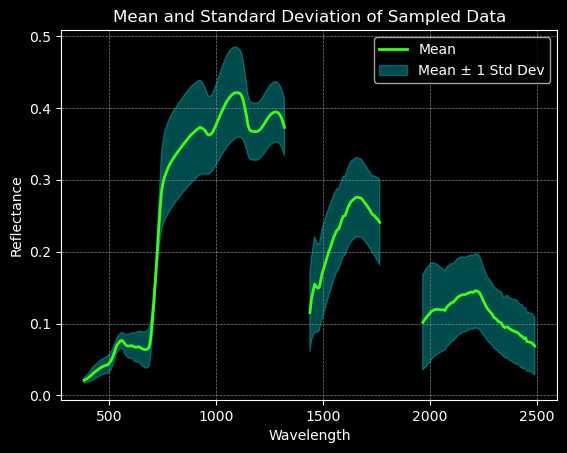

In [162]:
def plot_data(dat, wavelengths):
    # Plot the mean and standard deviation of the sampled data
    mean = np.nanmean(dat, axis=1)
    std_dev = np.nanstd(dat, axis=1)
    
    # Mask values less than 0 by setting them to NaN
    mean[mean < 0] = np.nan
    std_dev[std_dev < 0] = np.nan

    # Set the black background
    plt.style.use('dark_background')

    # Plot the mean with a neon color
    plt.plot(wavelengths, mean, label='Mean', color='#39FF14', linewidth=2)  # Neon green line

    # Plot the standard deviation as a shaded area with a neon color
    plt.fill_between(wavelengths, mean - std_dev, mean + std_dev, color='#00FFFF', alpha=0.3, label='Mean ± 1 Std Dev')  # Neon cyan shading

    # Customize the plot with labels, title, legend, and grid
    plt.xlabel('Wavelength', color='white')
    plt.ylabel('Reflectance', color='white')
    plt.title('Mean and Standard Deviation of Sampled Data', color='white')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

plot_data(dat, wavelengths)


In [163]:
print("Shape:", dat.shape)

# Remove wild values
dat = dat[:, np.nanmax(dat, axis=0) < 0.9]
print("Shape after removing wild values:", dat.shape)


if dat.shape[1] > 1000000:
    # Remove outliers using sklearn IsolationForest
    clf = IsolationForest(contamination=0.05)
    outliers = clf.fit_predict(dat.T)
    sampled_data = dat[:, outliers == 1].T
    # Print the proportion of outliers
    print(f'Proportion of outliers: {np.sum(outliers == -1) / len(outliers)}')

    # Subsample a maximum of 1 million pixels
    num_samples = 1000000
    sample_pixels = np.random.choice(sampled_data.shape[0], min(num_samples,sampled_data.shape[0]), replace=False)
    sampled_data = sampled_data[sample_pixels]
else:
    sampled_data = dat.T
    
print(sampled_data.shape)

Shape: (285, 22570)
Shape after removing wild values: (285, 22570)
(22570, 285)


### SMACC

In [164]:
def plot_endmembers(wavelengths, endmembers, title = '', legend_labels = []):
    """
    Plot endmember spectra with wavelengths.
    
    Parameters:
    - wavelengths: ndarray of shape (n_bands,), wavelength values
    - endmembers: ndarray of shape (n_endmembers, n_bands), endmember spectra
    """
    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        
        # Vectorized plotting using numpy operations
        wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
        
        # Plot all lines at once with optimized line properties
        lines = ax.plot(wavelengths_matrix, endmembers.T, 
                       linewidth=1.5,  # Optimal line width for performance
                       solid_capstyle='round',
                       antialiased=True)
        
        ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
        
        ax.set(xlabel='Wavelength',
               ylabel='Reflectance',
               title=title)
        
        for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                    ax.xaxis.label, ax.yaxis.label, ax.title):
            text.set_color('white')

        if len(legend_labels) ==0: legend_labels =[f'Endmember {i+1}' for i in range(endmembers.shape[0])]
        ax.legend(legend_labels,
                  framealpha=0.8,
                  loc='best',
                  ncol=1)

        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        fig.tight_layout()


Found 4 endmembers, current max residual norm is 0.6534

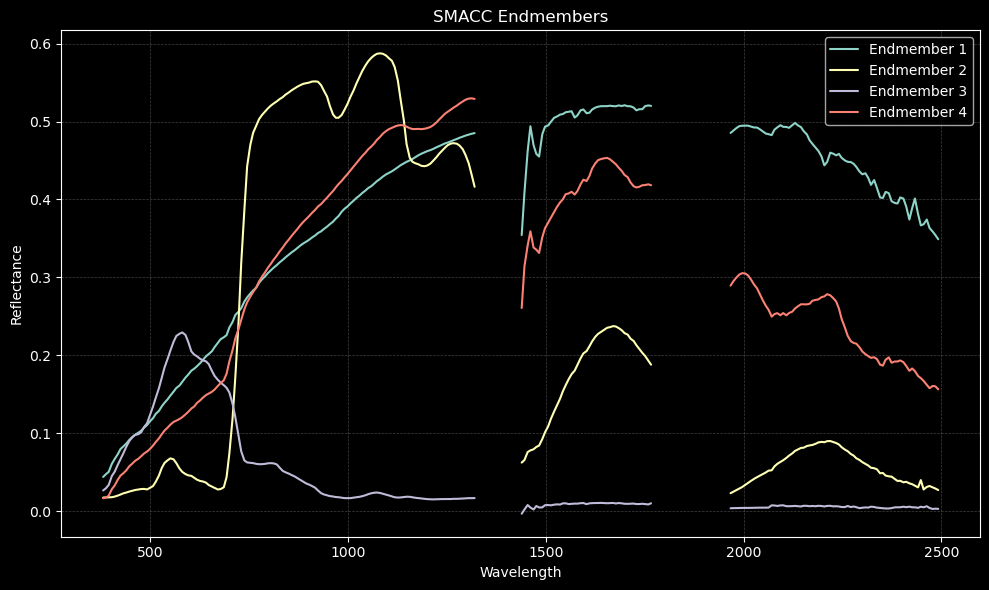

In [167]:
def smacc(spectra, min_endmembers=None, max_residual_norm=float('Inf')):
    '''Returns SMACC decomposition (H = F * S + R) matrices for an image or
    array of spectra.

    Let `H` be matrix of shape NxB, where B is number of bands, and N number of
    spectra, then if `spectra` is of the same shape, `H` will be equal to `spectra`.
    Otherwise, `spectra` is assumed to be 3D spectral image, and it is reshaped
    to match shape of `H`.

    Arguments:

        `spectra` (ndarray):

            Image data for which to calculate SMACC decomposition matrices.

        `min_endmembers` (int):

            Minimal number of endmembers to find. Defaults to rank of `H`,
            computed numerically with `numpy.linalg.matrix_rank`.

        `max_residual_norm`:

            Maximum value of residual vectors' norms. Algorithm will keep finding
            new endmembers until max value of residual norms is less than this
            argument. Defaults to float('Inf')

    Returns:
        3 matrices, S, F and R, such that H = F * S + R (but it might not always hold).
        F is matrix of expansion coefficients of shape N x num_endmembers.
        All values of F are equal to, or greater than zero.
        S is matrix of endmember spectra, extreme vectors, of shape num_endmembers x B.
        R is matrix of residuals of same shape as H (N x B).

        If values of H are large (few tousands), H = F * S + R, might not hold,
        because of numeric errors. It is advisable to scale numbers, by dividing
        by 10000, for example. Depending on how accurate you want it to be,
        you can check if H is really strictly equal to F * S + R,
        and adjust R: R = H - np.matmul(F, S).

    References:

        John H. Gruninger, Anthony J. Ratkowski, and Michael L. Hoke "The sequential
        maximum angle convex cone (SMACC) endmember model", Proc. SPIE 5425, Algorithms
        and Technologies for Multispectral, Hyperspectral, and Ultraspectral Imagery X,
        (12 August 2004); https://doi.org/10.1117/12.543794
    '''    
    # Flatten 3D spectral image to 2D if necessary
    H = spectra.reshape((-1, spectra.shape[2])) if spectra.ndim == 3 else spectra
    
    R = H.copy()
    Fs = []
    q = []  # Indices of selected vectors in S
    
    # Set default minimum endmembers
    if min_endmembers is None:
        min_endmembers = np.linalg.matrix_rank(H)

    residual_norms = np.linalg.norm(H, axis=1)
    current_max_residual_norm = np.max(residual_norms)
    
    if max_residual_norm is None:
        max_residual_norm = current_max_residual_norm / min_endmembers

    while len(q) < min_endmembers or current_max_residual_norm > max_residual_norm:
        idx = np.argmax(residual_norms)
        q.append(idx)
        
        # Calculate projection coefficients
        w = R[idx]
        wt = w / np.dot(w, w)
        On = np.dot(R, wt)
        alpha = np.ones_like(On)
        
        # Adjust alphas for oblique projection
        for k in range(len(Fs)):
            t = On * Fs[k][idx]
            t[t == 0.0] = 1e-10
            alpha = np.minimum(Fs[k] / t, alpha, where=t != 0.0)
        
        # Clip negative projection coefficients
        alpha[On <= 0.0] = 0.0
        alpha[idx] = 1.0
        
        # Calculate oblique projection coefficients
        Fn = alpha * On.clip(min=0.0)
        R -= np.outer(Fn, w)
        
        # Update existing factors
        for k in range(len(Fs)):
            Fs[k] -= Fs[k][idx] * Fn
            Fs[k] = Fs[k].clip(min=0.0)
        
        Fs.append(Fn)
        residual_norms = np.linalg.norm(R, axis=1)
        current_max_residual_norm = np.max(residual_norms)
        
        print(f'Found {len(q)} endmembers, current max residual norm is {current_max_residual_norm:.4f}\r', end='')

    # Correction as suggested in the SMACC paper.
    for k, s in enumerate(q):
        Fs[k][q] = 0.0
        Fs[k][s] = 1.0

    F = np.column_stack(Fs).T
    S = H[q]

    return S, F, R


# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S, F, R = smacc(sampled_data[:, valid_bands], min_endmembers=4, max_residual_norm=1)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='SMACC Endmembers')

smacc_endmembers = endmembers

### QHULL

Cumulative PCA Explained Variance = [0.72544795 0.97864306 0.99182147]


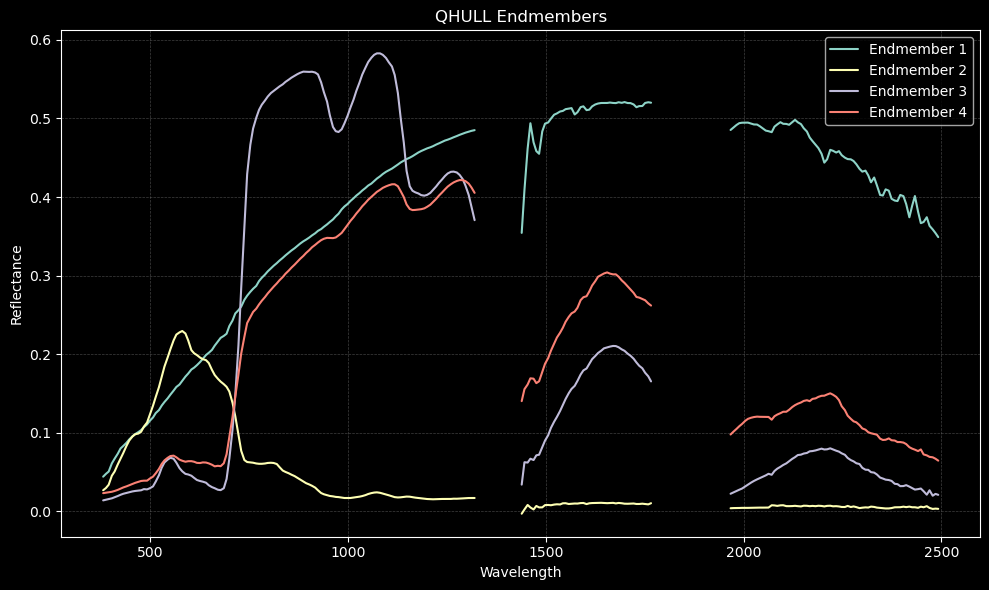

In [168]:
def qhull_endmembers(data,n_components=3):
    """
    Finds the edges of the data simplex using QHULL to find the endmembers.
    
    Parameters:
    data (numpy.ndarray): The input data, expected to be 2D (pixels x bands).
    subsize (int): The maximum number of pixels to use for the analysis.

    Returns:
    realsig (numpy.ndarray): The real signatures from the data.
    """


    # Perform PCA transformation
    pca = PCA(n_components=n_components)
    pc = pca.fit_transform(data)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # Use Qhull via ConvexHull to find the extreme points
    # Fx print extreme points (vertices) of convex hulls
    # W0.1 min distance above plane for outside points to approximate the convex hull
    # QbB  - scale the input to fit the unit cube
    hull = ConvexHull(pc, qhull_options='Fx W0.5 QbB')

    # Extract the real signatures
    realsig = data[hull.vertices]

    return realsig

# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S = qhull_endmembers(sampled_data[:, valid_bands], 3)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='QHULL Endmembers')

qhull_endmembers = endmembers

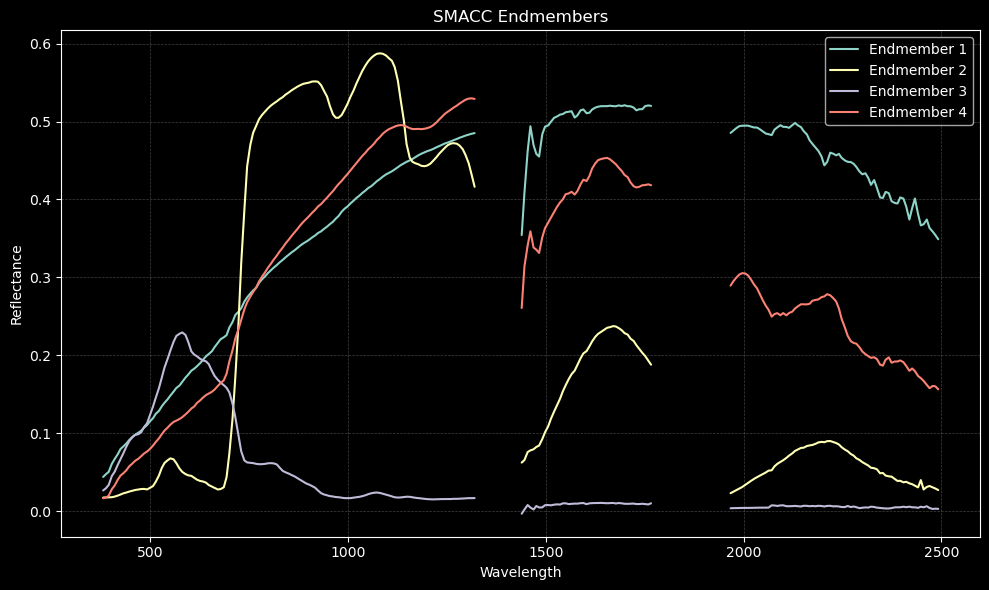

In [169]:
plot_endmembers(wavelengths, smacc_endmembers, title='SMACC Endmembers')

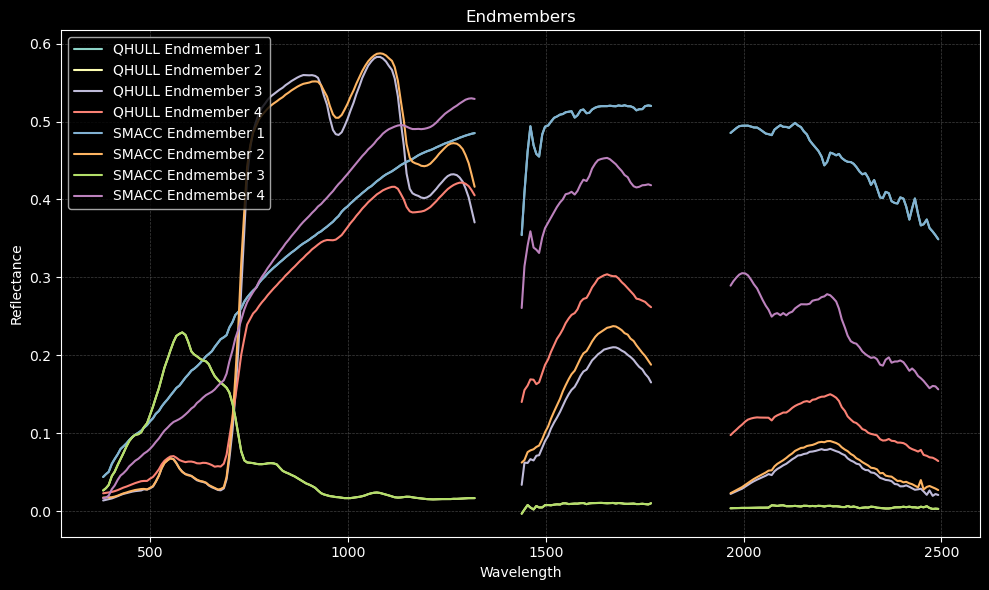

In [170]:
legend_labels = [f'QHULL Endmember {i+1}' for i in range(qhull_endmembers.shape[0])] + [f'SMACC Endmember {i+1}' for i in range(smacc_endmembers.shape[0])]
plot_endmembers(wavelengths, np.vstack([qhull_endmembers, smacc_endmembers, ]), title='Endmembers', legend_labels= legend_labels)

In [ ]:
#%matplotlib widget
%matplotlib inline
"""
Minimal Volume Convex Hull Optimization in 3D

This script finds a minimal-volume convex hull with N vertices that encloses
a given set of 3D points using global optimization (Differential Evolution).

Author: Peter Scarth
Date: 2025-02-18
"""

import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

def compute_hull_volume(points):
    """
    Compute the volume of the convex hull of given points.

    Parameters:
    - points: ndarray of shape (M, 3).

    Returns:
    - volume: float, volume of the convex hull. Returns np.inf if hull computation fails.
    """
    try:
        hull = ConvexHull(points)
        return hull.volume
    except:
        # If points are coplanar or otherwise degenerate
        return np.inf

def points_inside_hull(original_points, hull_vertices):
    """
    Check which original points are inside the convex hull defined by hull_vertices.

    Parameters:
    - original_points: ndarray of shape (M, 3), points to check.
    - hull_vertices: ndarray of shape (N, 3), vertices of the convex hull.

    Returns:
    - inside: ndarray of shape (M,), boolean array indicating whether each point is inside the hull.
    """
    try:
        delaunay = Delaunay(hull_vertices)
        return delaunay.find_simplex(original_points) >= 0
    except:
        # If the Delaunay triangulation fails (e.g., degenerate hull)
        return np.zeros(len(original_points), dtype=bool)

def define_bounds(original_points, N, padding=1.0):
    """
    Define the bounds for each coordinate of the N new vertices based on the original data.

    Parameters:
    - original_points: ndarray of shape (M, 3), original data points.
    - N: int, number of vertices for the new convex hull.
    - padding: float, extra space added to the bounds.

    Returns:
    - bounds: list of tuples, bounds for each variable in the optimizer.
    """
    mins = original_points.min(axis=0) - padding
    maxs = original_points.max(axis=0) + padding
    bounds = []
    for _ in range(N):
        for dim in range(3):
            bounds.append((mins[dim], maxs[dim]))
    return bounds



def objective(global_variables, original_points, N, penalty_weight=10, pca=None, bound_penalty_weight=1, max_reflectance=1):
    """
    Objective function to minimize: volume of the convex hull + penalties for points outside +
    penalties for inverse-transformed endmembers outside [0, 1].

    Parameters:
    - global_variables: ndarray of shape (3N,), flattened coordinates of N vertices.
    - original_points: ndarray of shape (M, 3), points to be enclosed.
    - N: int, number of vertices for the new convex hull.
    - penalty_weight: float, weight for the penalty term for points outside.
    - pca: PCA object, used for inverse transformation.
    - bound_penalty_weight: float, weight for the penalty term for bound violations.
    - max_reflectance: float, maximum reflectance value for bound violations.

    Returns:
    - total_cost: float, sum of hull volume and penalties.
    """
    # Reshape the variable vector into N x 3 points
    Q = global_variables.reshape((N, 3))
    
    try:
        hull = ConvexHull(Q)
        volume = hull.volume
    except:
        # Assign a large volume if hull computation fails
        return 1e12
    
    # Retrieve the hull vertices for Delaunay triangulation
    hull_vertices = Q[hull.vertices]
    
    # Check which original points are inside the hull
    inside = points_inside_hull(original_points, hull_vertices)
    num_outside = np.size(inside) - np.sum(inside)
    
    # Calculate penalty for points outside
    penalty = penalty_weight * num_outside
    
    # Additional penalty for inverse-transformed endmembers outside [0, Max Reflectance]
    if pca is not None:
        try:
            # Inverse transform to original space
            endmembers = pca.inverse_transform(Q)
            
            # Compute violations: any value <0 or >0.5
            violations = np.sum((endmembers < 0) | (endmembers > max_reflectance))
            
            # Apply penalty for each violation
            penalty += bound_penalty_weight * violations
        except Exception as e:
            # If inverse_transform fails, apply a large penalty
            penalty += 1e6
    
    # Total cost is volume plus penalties
    total_cost = volume + penalty
    
    return total_cost

def find_minimal_convex_hull_global(original_points, N, pca, penalty_weight=10, bound_penalty_weight=1, maxiter=1000, popsize=15, seed=None, max_reflectance=1):
    """
    Find the minimal-volume convex hull enclosing the original points using Differential Evolution.

    Parameters:
    - original_points: ndarray of shape (M, 3), points to enclose.
    - N: int, number of vertices for the new convex hull (must be >=4 for 3D).
    - pca: PCA object, used for inverse transformation.
    - penalty_weight: float, weight for the penalty term for points outside.
    - bound_penalty_weight: float, weight for the penalty term for bound violations.
    - maxiter: int, maximum number of iterations for the optimizer.
    - popsize: int, population size multiplier (default 15).
    - seed: int or None, random seed for reproducibility.

    Returns:
    - optimized_vertices: ndarray of shape (N, 3), optimized positions of hull vertices.
    - result: OptimizeResult object, contains information about the optimization.
    """
    if N < 4:
        raise ValueError("N must be at least 4 to form a 3D convex hull.")
    
    # Define bounds for the optimizer
    bounds = define_bounds(original_points, N, padding=1.0)
    
    # Perform Differential Evolution
    result = differential_evolution(
        func=objective,
        bounds=bounds,
        args=(original_points, N, penalty_weight, pca, bound_penalty_weight, max_reflectance),
        strategy='best1bin',
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-6,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=seed,
        disp=False, #True,
        polish=True,
        init='latinhypercube',
        updating='deferred',  # Improves performance by deferring updates
        workers=1  # Use all available CPU cores
    )
    
    # Extract optimized vertices
    optimized_vertices = result.x.reshape((N, 3))
    return optimized_vertices, result

def plot_convex_hull(original_points, hull_vertices, title='Minimal Volume Convex Hull'):
    """
    Plot the original points and the optimized convex hull in 3D.

    Parameters:
    - original_points: ndarray of shape (M, 3), original data points.
    - hull_vertices: ndarray of shape (N, 3), vertices of the optimized convex hull.
    - title: str, title of the plot.
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot original points
    ax.scatter(original_points[:,0], original_points[:,1], original_points[:,2],
               color='blue', alpha=0.3, label='Original Points')
    
    # Compute convex hull of optimized vertices
    try:
        hull = ConvexHull(hull_vertices)
        for simplex in hull.simplices:
            simplex = np.append(simplex, simplex[0])  # To create a closed loop
            ax.plot(hull_vertices[simplex, 0], hull_vertices[simplex, 1], hull_vertices[simplex, 2],
                    'r-')
        
        # Optionally, plot the vertices
        ax.scatter(hull_vertices[:,0], hull_vertices[:,1], hull_vertices[:,2],
                   color='red', label='Optimized Hull Vertices')
    except Exception as e:
        print("Failed to compute convex hull for visualization:", e)
    
    ax.set_title(title)
    ax.legend()
    
    plt.show()


# Find the edgemembers
valid_bands = ~np.all(sampled_data < 0, axis=0)
pca = PCA(n_components=3)
pc = pca.fit_transform(sampled_data[:, valid_bands])

# Get at least start_vertices edge members
start_vertices = 10
w_val=0.5
num_vertices = 4
while num_vertices < start_vertices:
    hull = ConvexHull(pc, qhull_options=f'Fx W{w_val} QbB')
    num_vertices = len(hull.vertices)
    w_val -= 0.01

print(f"Found {num_vertices} edge members with w={w_val:.2f}")
edgemembers = pc[hull.vertices]
print(f"Starting with {len(edgemembers)} edge members.")

# Parameters
N = 4 # Number of vertices for the new convex hull (>=4)
penalty_weight = 5.0 # Penalty for points outside the hull
bound_penalty_weight = 0.1 # Penalty for inverse-transformed endmembers outside [0, 1]      
maxiter = 100000 # Maximum number of iterations for the optimizer
popsize = 15 # Population size multiplier
seed = None # Random seed for reproducibility

# Find minimal convex hull using global optimizer
print(f"Starting optimization to find a convex hull with {N} vertices...")
optimized_vertices, optimization_result = find_minimal_convex_hull_global(
    edgemembers,
    N=N,
    pca=pca,
    penalty_weight=penalty_weight,
    bound_penalty_weight=bound_penalty_weight,
    maxiter=maxiter,
    popsize=popsize,
    seed=seed,
    max_reflectance=0.7
)

# Display optimization results
print("\nOptimization Results:")
print(f"Success: {optimization_result.success}")
print(f"Message: {optimization_result.message}")
print(f"Number of Function Evaluations: {optimization_result.nfev}")
final_volume = compute_hull_volume(optimized_vertices)
print(f"Final Volume of Optimized Convex Hull: {final_volume:.4f}")

# Verify that all points are inside the optimized hull
try:
    hull = ConvexHull(optimized_vertices)
    hull_vertices = optimized_vertices[hull.vertices]
    inside = points_inside_hull(edgemembers, hull_vertices)
    num_inside = np.sum(inside)
    print(f"Number of Original Points Inside the Optimized Hull: {num_inside} / {len(edgemembers)}")
except Exception as e:
    print("Failed to verify point enclosure:", e)

# Plot the results
plot_convex_hull(edgemembers, optimized_vertices, title='Minimal Volume Convex Hull')

    

# Use the inverse PCA transformation to get the endmembers in the original space
S = pca.inverse_transform(hull_vertices)
# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='Optimized Endmembers')



# Save the PCA, the optimized vertices, and the endmembers
joblib.dump(pca, 'pca.joblib')
np.save('optimized_vertices.npy', optimized_vertices)
np.save('endmembers.npy', endmembers)


minhull_endmembers = endmembers


Found 10 edge members with w=0.05
Starting with 10 edge members.
Starting optimization to find a convex hull with 4 vertices...


In [ ]:
# Setup inputs, outputs, and other configurations
sum_to_one = 4
pca = joblib.load('pca.joblib')
optimized_vertices = np.load('optimized_vertices.npy')
weighted_endmembers = np.vstack((optimized_vertices.T, np.ones(optimized_vertices.shape[0]) * sum_to_one))

In [ ]:
np.isnan(nbar = nbar[valid_bands]).mean()

In [ ]:
np.isnan(sampled_data).mean(), np.isnan(sampled_data).mean()

## Unmixing

In [ ]:
import numpy as np
from scipy.optimize import nnls

bare_green_dry = [[1,2], [0], [3]] # Bare, green, dry endmember mapping

nbar = ds.isel(time=0).reflectance.transpose('bands','latitude','longitude').data
#valid_bands = ~np.all(nbar.reshape(nbar.shape[0],-1).T < 0, axis=0)
nbar = nbar[valid_bands]
#valid_bands = ~np.any(np.isnan(nbar.reshape(nbar.shape[0],-1).T), axis=0)
#nbar = nbar[valid_bands]
mask = np.all(np.isnan(nbar), axis=0)

# Flatten reflectance and perform PCA in one step to save memory
original_shape = nbar.shape
nbar_transformed = pca.transform(nbar.reshape(original_shape[0], -1).T).T

# Precompute ones array outside the loop
ones_array = np.full((1, nbar_transformed.shape[1]), sum_to_one)

# Combine weighted reflectance with ones_array using np.vstack
weightedReflectance = np.vstack((nbar_transformed, ones_array))

# Initialize fractions array with zeros
fractions = np.zeros((weighted_endmembers.shape[1], nbar_transformed.shape[1]), dtype=np.float32)

# Use vectorization where possible
for i in range(weightedReflectance.shape[1]):
    fractions[:, i], _ = nnls(weighted_endmembers, weightedReflectance[:, i])

# Reshape, clip, and convert to 8-bit data
fractions = np.clip(np.rint(100.0 * fractions.reshape((-1,original_shape[1], original_shape[2]))), 0, 200).astype('uint8')

# Compute fractions for bare, green, dry vegetation
fractions_bgd = np.zeros((3, original_shape[1], original_shape[2]), dtype=np.uint8)
fractions_bgd[0] = fractions[bare_green_dry[0]].sum(axis=0)
fractions_bgd[1] = fractions[bare_green_dry[1]].sum(axis=0)
fractions_bgd[2] = fractions[bare_green_dry[2]].sum(axis=0)

# Apply mask
fractions_bgd[:, mask] = 255
fractions[:, mask] = 255


In [101]:
fractions.shape

NameError: name 'fractions' is not defined

In [166]:
import time
from cvxopt import matrix, solvers

class FCLSU:
    def __init__(self):
        pass

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

    @staticmethod
    def _numpy_None_vstack(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.vstack([A1, A2])

    @staticmethod
    def _numpy_None_concatenate(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.concatenate([A1, A2])

    @staticmethod
    def _numpy_to_cvxopt_matrix(A):
        A = np.array(A, dtype=np.float64)
        if A.ndim == 1:
            return matrix(A, (A.shape[0], 1), "d")
        else:
            return matrix(A, A.shape, "d")

    def solve(self, Y, E):
        """
        Performs fully constrained least squares of each pixel in M
        using the endmember signatures of U. Fully constrained least squares
        is least squares with the abundance sum-to-one constraint (ASC) and the
        abundance nonnegative constraint (ANC).
        Parameters:
            Y: `numpy array`
                2D data matrix (L x N).
            E: `numpy array`
                2D matrix of endmembers (L x p).
        Returns:
            X: `numpy array`
                2D abundance maps (p x N). d
        References:
            Daniel Heinz, Chein-I Chang, and Mark L.G. Fully Constrained
            Least-Squares Based Linear Unmixing. Althouse. IEEE. 1999.
        Notes:
            Three sources have been useful to build the algorithm:
                * The function hyperFclsMatlab, part of the Matlab Hyperspectral
                Toolbox of Isaac Gerg.
                * The Matlab (tm) help on lsqlin.
                * And the Python implementation of lsqlin by Valera Vishnevskiy, click:
                http://maggotroot.blogspot.ca/2013/11/constrained-linear-least-squares-in.html
                , it's great code.
        """
        tic = time.time()
        assert len(Y.shape) == 2
        assert len(E.shape) == 2

        L1, N = Y.shape
        L2, p = E.shape

        assert L1 == L2

        # Reshape to match implementation
        M = np.copy(Y.T)
        U = np.copy(E.T)

        solvers.options["show_progress"] = False

        U = U.astype(np.double)

        C = self._numpy_to_cvxopt_matrix(U.T)
        Q = C.T * C

        lb_A = -np.eye(p)
        lb = np.repeat(0, p)
        A = self._numpy_None_vstack(None, lb_A)
        b = self._numpy_None_concatenate(None, -lb)
        A = self._numpy_to_cvxopt_matrix(A)
        b = self._numpy_to_cvxopt_matrix(b)

        Aeq = self._numpy_to_cvxopt_matrix(np.ones((1, p)))
        beq = self._numpy_to_cvxopt_matrix(np.ones(1))

        M = np.array(M, dtype=np.float64)
        M = M.astype(np.double)
        X = np.zeros((N, p), dtype=np.float32)
        for n1 in range(N):
            d = matrix(M[n1], (L1, 1), "d")
            q = -d.T * C
    
            sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, None)["x"]
            X[n1] = np.array(sol).squeeze()
        tac = time.time()
        print(f"{self} took {tac - tic:.2f}s")
        return X.T
    
model = FCLSU()

# Endmembers extraction
E0 = smacc_endmembers.T # 2D matrix Lxp

data = ds.isel(time=0).reflectance.transpose('bands','latitude','longitude').data

# Call data to return HSI
n1, n2, n3 = data.shape
Y = data.reshape(n1, n2*n3)

# Abundances estimation
A0 = model.solve(Y, E0)

frac = A0.reshape(A0.shape[0], n2,n3)

ModuleNotFoundError: No module named 'cvxopt'

In [ ]:
idx = 800
plt.plot(ds_good.bands.values, Y[:, idx] , label='Observed')
plt.plot(ds_good.bands.values, np.dot(A0.T, E0.T)[idx], label='Mixed')
plt.plot(ds_good.bands.values, A0[0, idx]*E0[:,0], label='SOIL')
plt.plot(ds_good.bands.values, A0[1, idx]*E0[:,1], label='PV')
plt.plot(ds_good.bands.values, A0[2, idx]*E0[:,1], label='NPV')
plt.legend()